# Modelgrid and intersection

The first part of this notebook is focused on the `flopy.discretization.Grid` (modelgrid) object(s). The modelgrid object(s) are a relatively new addition to FloPy's capabilities and are the backbone of plotting, exporting, and GIS data processing within FloPy. These objects are automatically created when a model is loaded. Alternatively they can also be created as a stand alone object. 

There are three types of modelgrids:

* `StructuredGrid`: the StructuredGrid object is created for rectilinear grids. i.e. models that use a DIS file for discretization
* `VertexGrid`: the VertexGrid object is for discretizations that are defined by vertices (e.g., DISV packages)
* `UnstructuredGrid`: the UnstructuredGrid object is for unstructured discretizations (e.g., DISU and MODFLOW-USG)

These objects all have a common interface defined by the base `Grid` class. What this means for the user is if they want to get the cell center coordinates from a modelgrid, the function call is identical on all three grids.

The best way to learn about these classes is by checking them out. 

In [3]:
import os
import flopy
from flopy.utils.gridgen import Gridgen
from flopy.utils import GridIntersect, Raster

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pdy
import geopandas as gpd
import shapely.geometry


import pydaymet
import utm

# pd.options.mode.chained_assignment = None
data_path = os.path.join("data", "modelgrid_intersection")
x = matplotlib.get_backend()
x

'module://matplotlib_inline.backend_inline'

## Grids

## StructuredGrid

Let's start with the most common type of MODFLOW modelgrid, the `StructuredGrid`

#### First we'll build one from scratch 

In [4]:
nrow = 20
ncol = 15
nlay = 1

grad = np.expand_dims(np.linspace(50, 100, nrow), axis=1)[::-1]
top = np.ones((nrow, ncol)) * grad
botm = np.zeros((nlay, nrow, ncol))
botm[0, :, :] = top - 50 
delr = np.full((ncol,), 250)
delc = np.full((nrow,), 150)
ibound = np.ones((nlay, nrow, ncol))
ibound[0, 4:10, 4:8] = 0

modelgrid = flopy.discretization.StructuredGrid(
    delc,
    delr,
    top,
    botm,
    ibound,
)
print(modelgrid)
print(type(modelgrid))

xll:0.0; yll:0.0; rotation:0.0; units:undefined; lenuni:0
<class 'flopy.discretization.structuredgrid.StructuredGrid'>


Let's take a look at our modelgrid visually

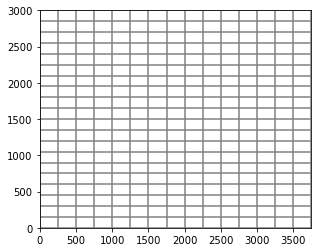

In [5]:
modelgrid.plot();

This is great, but what if we want to orient it in space and add a coordinate reference system so we can do further processing? 

The `set_coord_info()` method allows us to update the coordinate offsets, rotation of the grid, and even add projection information.

In [6]:
xoff = 2345678
yoff = 1234567
angrot = -15
epsg = 32610  # utm zone 10N

modelgrid.set_coord_info(xoff=xoff, yoff=yoff, angrot=angrot, epsg=epsg)

C:\Users\jlarsen\Desktop\flopy-dev\flopy\flopy\utils\crs.py:121: PendingDeprecationWarning: the epsg argument will be deprecated and will be removed in version 3.6. Use crs instead.
  warnings.warn(


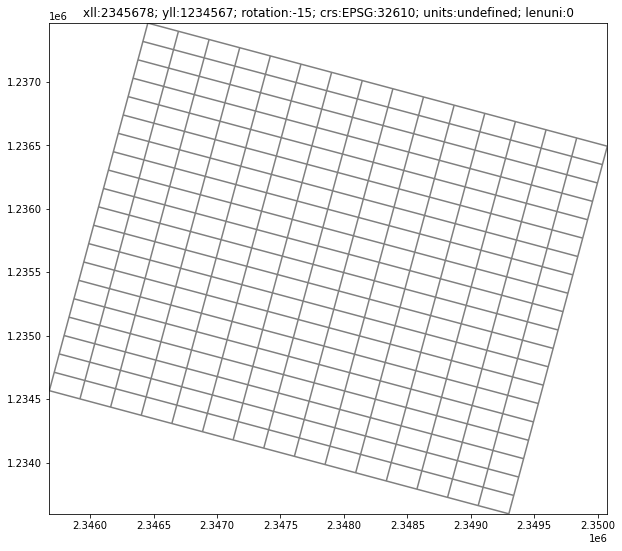

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = modelgrid.plot(ax=ax)
plt.title(str(modelgrid));

### Getting cell centers and cell vertices

* Cell centers can be returned to the user through the `.xcellcenters`, `.ycellcenter`, and `.zcellcenter` properties.
* Cell vertices can be returned to the user through the `.xvertices` and `.yvertices` properties

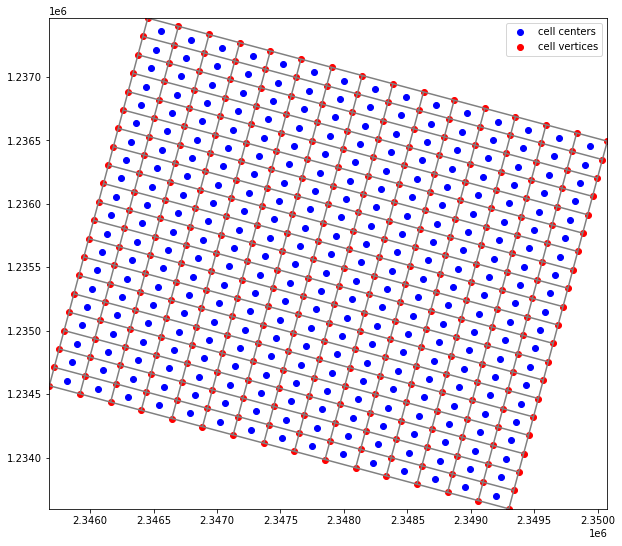

In [8]:
xc, yc = modelgrid.xcellcenters, modelgrid.ycellcenters
xv, yv = modelgrid.xvertices, modelgrid.yvertices

fig, ax = plt.subplots(figsize=(10, 10))
modelgrid.plot()
ax.scatter(xc.ravel(), yc.ravel(), c="b", label="cell centers")
ax.scatter(xv.ravel(), yv.ravel(), c="r", label="cell vertices")
plt.legend(loc=0);

### Getting the ibound/idomain array

The `.idomain` method returns the ibound/idomain array

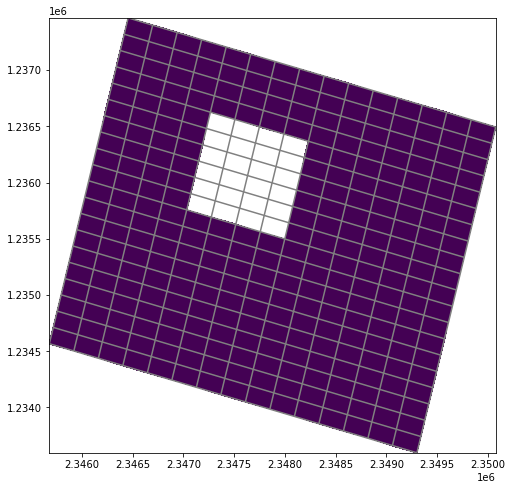

In [9]:
ibound = modelgrid.idomain

fig, ax = plt.subplots(figsize=(8, 8))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
pmv.plot_grid()
pmv.plot_array(ibound, masked_values=[0,]);

### Getting the model top, bottom, delc, and delr

The model top, bottom, delc, and delr can be accessed from the modelgrid using `.top`, `.bottom`, `.delc`, and `.delr`.

In [10]:
top = modelgrid.top
botm = modelgrid.botm
delc = modelgrid.delc
delr = modelgrid.delr
top, botm, delc, delr

(array([[100.        , 100.        , 100.        , 100.        ,
         100.        , 100.        , 100.        , 100.        ,
         100.        , 100.        , 100.        , 100.        ,
         100.        , 100.        , 100.        ],
        [ 97.36842105,  97.36842105,  97.36842105,  97.36842105,
          97.36842105,  97.36842105,  97.36842105,  97.36842105,
          97.36842105,  97.36842105,  97.36842105,  97.36842105,
          97.36842105,  97.36842105,  97.36842105],
        [ 94.73684211,  94.73684211,  94.73684211,  94.73684211,
          94.73684211,  94.73684211,  94.73684211,  94.73684211,
          94.73684211,  94.73684211,  94.73684211,  94.73684211,
          94.73684211,  94.73684211,  94.73684211],
        [ 92.10526316,  92.10526316,  92.10526316,  92.10526316,
          92.10526316,  92.10526316,  92.10526316,  92.10526316,
          92.10526316,  92.10526316,  92.10526316,  92.10526316,
          92.10526316,  92.10526316,  92.10526316],
        [ 89

## Class exercise 1:

Assume that the modelgrid is currently in meters and we want our grid to be in feet. Create a new modelgrid object from the existing one where the discretization is in feet.

make a plot of the new modelgrid after it has been created

### Finding a cell's nearest neighbors

Imagine that we want to find the nearest neighbors of a cell for some reason. The modelgrid has a built in method to 1) internally construct a table of nearest neighbors and 2) return the nearest neighbors for a given cell to the user.

In [9]:
cell = (0, 0, 5)

neighbors = modelgrid.neighbors(*cell)
neighbors

[(0, 1, 5), (0, 0, 4), (0, 0, 6)]

### Finding grid cells by point location

If we want to find a cell number based on x, y coordinate location the model grid has a built in `.intersect()` method that takes `x`, `y`, and an optional `z` coordinate and returns the cell number 

In [10]:
x, y, z = 2348000, 1235000, 25

rowcol = modelgrid.intersect(x, y) # without z
layrowcol = modelgrid.intersect(x, y, z) # with z location

f"{rowcol=}, {layrowcol=}"

'rowcol=(13, 8), layrowcol=(0, 13, 8)'

## Vertex model grid

The vertex model grid is produced for MODFLOW model discretizations that are defined by verticies (`DISV`). We can build a quadtree vertex grid from an exiting structured modelgrid using the gridgen utility and the `Gridgen` class.

First let's unrotate the grid coordinates of our structured grid to make this easy

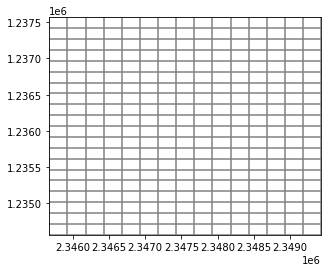

In [11]:
modelgrid.set_coord_info(angrot=0)
modelgrid.plot();

Lets load a couple of shapefiles to help with creating the quadtree

In [12]:
active_shp = os.path.join(data_path, "active_area.shp")
refine_shp = os.path.join(data_path, "refined_area.shp")

active = gpd.read_file(active_shp)
refined = gpd.read_file(refine_shp)

Now let's plot these areas on the grid to visualize them

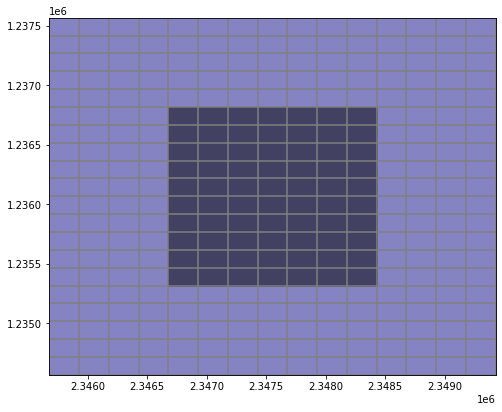

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))

pmv = flopy.plot.PlotMapView(modelgrid=modelgrid)
pmv.plot_grid()
# active.geometry.to_list()
pmv.plot_shapes(active.geometry.to_list(),  alpha=0.5, cmap='plasma')
pmv.plot_shapes(refined.geometry.to_list(), alpha=0.5, cmap='magma');

### Generate the quadtree grid using `Gridgen`

In [14]:
g = Gridgen(modelgrid, model_ws=data_path)
g.add_refinement_features(refined.geometry.to_list(), "polygon", 1, [0,])
g.build(verbose=False)

#### Create a vertex model grid from the results

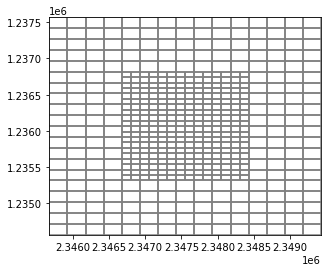

In [15]:
gridprops = g.get_gridprops_vertexgrid()
vertexgrid = flopy.discretization.VertexGrid(**gridprops)
vertexgrid.plot();

### Getting the modelgrid's shape


In [16]:
shape = vertexgrid.shape
shape

(1, 510)

## Class Exercise 2: 

Find and plot all of the nearest neighbors at node 79 on the vertex modelgrid.

**Hint**: Use `flopy.plot.PlotMapView` for your plotting, and plot a boolean (1, 0) array with the cells that are not neighbors masked out.


## UnstructuredGrid

The `UnstructuredGrid` class is used with MODFLOW-USG and MODFLOW-6 DISU type discretizations. We can also create an `UnstructuredGrid` object from the `Gridgen` results

In [17]:
gridprops = g.get_gridprops_unstructuredgrid()

ugrid = flopy.discretization.UnstructuredGrid(**gridprops)
ugrid, type(ugrid)

(xll:0.0; yll:0.0; rotation:0.0; units:undefined; lenuni:0,
 flopy.discretization.unstructuredgrid.UnstructuredGrid)

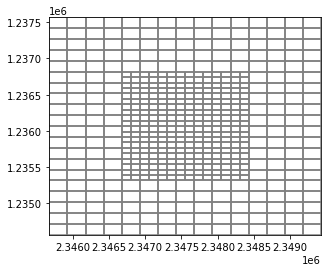

In [18]:
ugrid.plot();

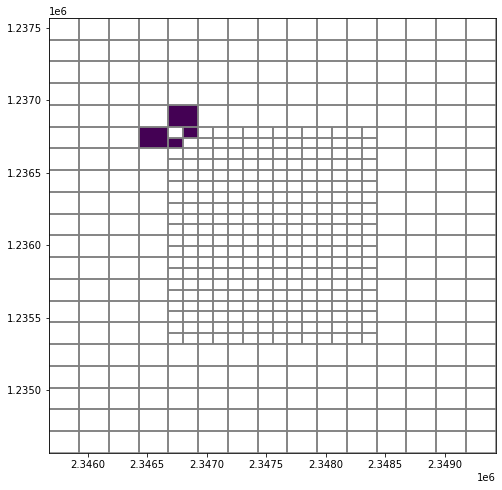

In [19]:
neighbors = ugrid.neighbors(79)
arr = np.zeros(ugrid.shape, dtype=int)
arr[neighbors] = 1

fig, ax = plt.subplots(figsize=(8, 8))

pmv = flopy.plot.PlotMapView(ax=ax, modelgrid=ugrid)
pmv.plot_grid()
pmv.plot_array(arr, masked_values=[0,]);

## Intersecting geospatial data

In this part of the lesson we will intersect geospatial data with a modelgrid and begin building a simple adaptation of the Sagehen Creek model, near Truckee, CA. While building this model, we'll work with shapefile and raster data. As we build the model FloPy's intersection capabilities will be presented.

Let's start by getting the basin boundary. For the Sagehen Creek model, we're interested in the contributing area for [USGS gage 10343500](https://waterdata.usgs.gov/ca/nwis/uv/?site_no=10343500&PARAmeter_cd=00065,00060) 

In [20]:
import pynhd as nhd

nldi = nhd.NLDI()
station_id = "10343500"

basin = nldi.get_basins(station_id)

# if pynhd is acting up load shapefile from disk
# basin = gpd.read_file(os.path.join(data_path, "sagehen_basin.shp"))

basin

,geometry
identifier,
10343500,"POLYGON ((-120.25104 39.40471, -120.25613 39.4..."


First thing that we notice is that the basin polygon is projected in decimal degrees, which is not good for modeling. An equal area projection would be better suited for this application

In [21]:

epsg = 26911  # NAD83 utm zone 11 N, epsg: 26911
basin = basin.to_crs(epsg=epsg)
basin

,geometry
identifier,
10343500,"POLYGON ((220068.269 4366733.672, 219647.034 4..."


<AxesSubplot:>

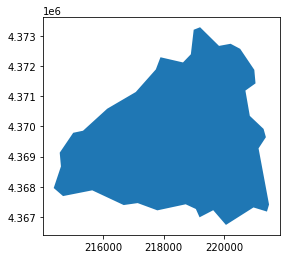

In [22]:
basin.plot()

We can now get our basin's bounding box using `.bounds`, buffer it, and then begin creating a modelgrid based on the basin boundary.

In [23]:
cellsize = 90  # 90 m grid
bounds = basin.bounds
print(bounds)
xmin = bounds.loc[station_id, "minx"] - (cellsize * 1)
ymin = bounds.loc[station_id, "miny"] - (cellsize * 1)
xmax = bounds.loc[station_id, "maxx"] + (cellsize * 1)
ymax = bounds.loc[station_id, "maxy"] + (cellsize * 1)

                     minx          miny           maxx          maxy
identifier                                                          
10343500    214358.156816  4.366734e+06  221497.087128  4.373287e+06


Calculate the number of rows and columns the model will have and then create a delc and delr array.

In [24]:
dx = xmax - xmin
dy = ymax - ymin

nlay = 1
nrow = np.ceil(dy / cellsize).astype(int)
ncol = np.ceil(dx / cellsize).astype(int)
delr = np.full((ncol,), cellsize)
delc = np.full((nrow,), cellsize)

# let's create a fake top and bottom for now
top = np.full((nrow, ncol), 100)
botm = np.full((nlay, nrow, ncol), 0)

Now we can create a minimal modelgrid from the information we have

In [25]:
modelgrid = flopy.discretization.StructuredGrid(
    delc,
    delr,
    top=top,
    botm=botm,
    nlay=nlay,
    xoff=xmin,
    yoff=ymin,
    epsg=epsg
)
print(modelgrid)
print(modelgrid.is_complete)

xll:214268.15681551897; yll:4366643.672008078; rotation:0.0; proj4_str:epsg:26911; units:undefined; lenuni:0
False


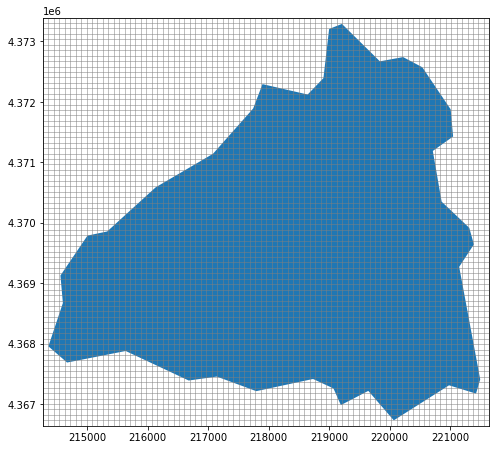

In [26]:
fig, ax = plt.subplots(figsize=(8, 8))

ax = basin.plot(ax=ax)
modelgrid.plot(ax=ax, lw=0.5);

Fantastic! The modelgrid has been created and it completely overlays the contributing area.

### Intersecting a polygon with the modelgrid

FloPy has a utility named `GridIntersect` that allows the user to intersect points, polygons, and polylines with modelgrid objects. 

In this example, the basin boundary will be intersected with the modelgrid to create the active and inactive extents of the model. The `.intersect()` method returns a numpy recarry with cellids, verticies, cell areas, and shapely polygon objects.

In [27]:
gx = GridIntersect(modelgrid)

result = gx.intersect(basin.loc[station_id, "geometry"])
result.cellids

array([(1, 52), (1, 53), (1, 54), ..., (73, 64), (73, 65), (73, 66)],
      dtype=object)

create the ibound/idomain array (active and incative model cells)

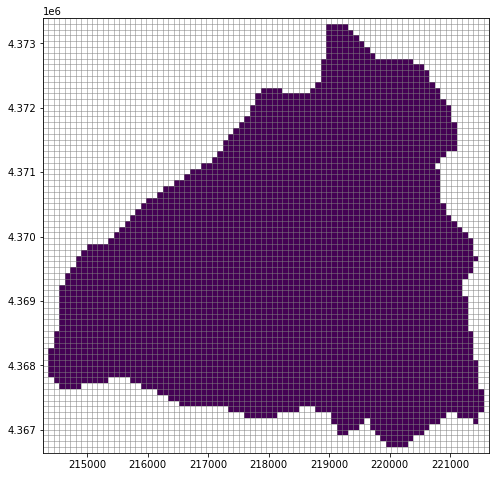

In [28]:
ibound = np.zeros((nlay, nrow, ncol))
i, j = zip(*result.cellids)
ibound[:, i, j] = 1

fig, ax = plt.subplots(figsize=(8, 8))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
pmv.plot_grid(lw=0.5)
pmv.plot_array(ibound, masked_values=[0], cmap="viridis")

### Intersecting raster data with a modelgrid

FloPy's `Raster` class allows us to intersect and resample raster data to the model grid. This class is useful for resampling a number of gridded products such as: Digital Elevation Model data, land cover data, and gridded climate data.

The first example of using the `Raster` class will be to resample Digital Elevation Model (DEM) data to define the land surface of the Sagehen model

In [29]:
dem_file = os.path.join(data_path, "dem_30m.img")

raster = Raster.load(dem_file)

#### Now that the raster is loaded we can resample it

The `resample_to_grid()` method performs geostatistics and returns an array in the shape of the modelgrid. Options for resampling include `"nearest"`, `"linear"` (bilinear), `"cubic"` (bicubic), `"max"`, `"min"`, `"mean"`, `"median"`, and `"mode"` (most common value).

In [30]:
# let's get the nearest neighbor elevations
dem_data = raster.resample_to_grid(
    modelgrid,
    band=raster.bands[0],
    method="nearest"
)
dem_data

c:\users\jlarsen\desktop\flopy-dev\flopy\utils\rasters.py:379: UserWarning: multithread option has been deprecated and will be removed in flopy version 3.3.8
  warnings.warn(


array([[2288.88427734, 2273.79296875, 2263.59692383, ..., 2035.27868652,
        2020.77258301, 2011.82592773],
       [2308.66918945, 2301.82080078, 2284.20483398, ..., 2037.7668457 ,
        2022.42944336, 2011.48937988],
       [2326.71118164, 2321.3112793 , 2301.70703125, ..., 2042.32263184,
        2025.94592285, 2015.38793945],
       ...,
       [2207.31152344, 2229.87426758, 2239.453125  , ..., 2112.20751953,
        2095.49414062, 2073.16308594],
       [2176.74121094, 2186.13769531, 2201.04858398, ..., 2095.2331543 ,
        2074.06396484, 2051.18530273],
       [2156.98022461, 2157.87744141, 2164.14770508, ..., 2077.35131836,
        2053.95043945, 2035.44116211]])

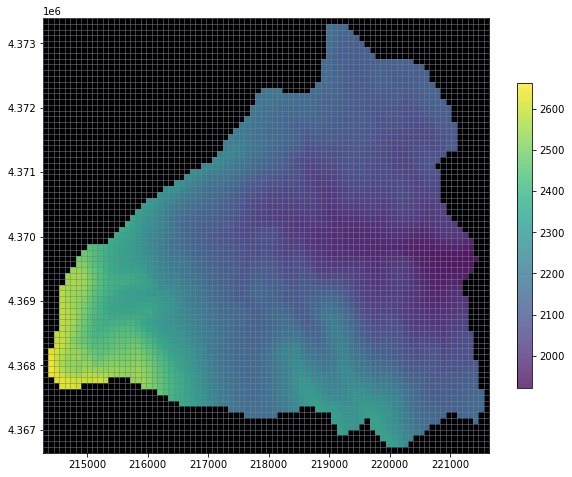

In [31]:
# Now let's plot it up and see what we have
fig, ax = plt.subplots(figsize=(10, 8)) 
pmv = flopy.plot.PlotMapView(ax=ax, modelgrid=modelgrid)

pmv.plot_grid(lw=0.5, zorder=3)
pc = pmv.plot_array(dem_data, alpha=0.75, zorder=1, cmap="viridis")
pmv.plot_array(ibound, masked_values=[1], cmap="magma", zorder=2)
plt.colorbar(pc, shrink=0.7);

### Start creating model files from the data we've gathered so far.

At this point we have almost everything we need to begin creating a model discretization package. The only thing left to calculate is the model bottom. Let's assume bedrock 150 m below land surface throughout the basin and begin creating our model. 


We'll first start by creating our simulation object and adding a solver and the time discretization. This model will be a year long with 12 stress periods and a daily time step

In [32]:
sim = flopy.mf6.MFSimulation("sagehen", sim_ws=data_path)
ims = flopy.mf6.ModflowIms(sim, complexity="COMPLEX")
nper = 12
perlen = (31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31)
period_data = [(i, i, 1.0) for i in perlen]
tdis = flopy.mf6.ModflowTdis(
    sim,
    nper=12,
    perioddata=period_data,
    time_units="days"
)

Now to create the Groundwater flow model object and add the dis file to it

In [33]:
gwf = flopy.mf6.ModflowGwf(
    sim,
    modelname='sagehen',
    save_flows=True,
)

# add the dis package
botm = np.expand_dims(dem_data, axis=0) - 200
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nrow=modelgrid.nrow,
    ncol=modelgrid.ncol,
    delr=modelgrid.delr,
    delc=modelgrid.delc,
    top=dem_data,
    botm=botm,
    idomain=ibound
)

gwf

name = sagehen
model_type = gwf6
version = mf6
model_relative_path = .

###################
Package dis
###################

package_name = dis
filename = sagehen.dis
package_type = dis
model_or_simulation_package = model
model_name = sagehen



We can also add an initial conditions file to the model. Let's assume water level begins at 5 meters below land surface

In [34]:
ic = flopy.mf6.ModflowGwfic(gwf, strt=dem_data - 5)
gwf

name = sagehen
model_type = gwf6
version = mf6
model_relative_path = .

###################
Package dis
###################

package_name = dis
filename = sagehen.dis
package_type = dis
model_or_simulation_package = model
model_name = sagehen


###################
Package ic
###################

package_name = ic
filename = sagehen.ic
package_type = ic
model_or_simulation_package = model
model_name = sagehen



And we can create our NPF and STO packages using values from literature

In [35]:
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    save_flows=True,
    save_specific_discharge=True,
    k=0.022  # value from Larsen et al, 2022
)

sto = flopy.mf6.ModflowGwfsto(
    gwf,
    save_flows=True,
    iconvert=1,
    ss=1e-07,  # values from Larsen et al, 2022
    sy=0.2
)

We can also add a OC package now

In [36]:
# build output control package
budget_file = "sagehen.cbc"
head_file = "sagehen.hds"
saverecord = {i: [("HEAD", "ALL"), ("BUDGET", "ALL")] for i in range(gwf.nper)}
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    budget_filerecord=budget_file,
    head_filerecord=head_file,
    saverecord=saverecord,
)

### Getting and processing daymet climate data

In [40]:
import pydaymet as daymet
import utm


xmin, xmax, ymin, ymax = modelgrid.extent

# convert UTM to decimal lat lon for daymet query
# ymin, xmin = utm.to_latlon(ext[0], ext[2], 11, "N")
# ymax, xmax = utm.to_latlon(ext[1], ext[3], 11, "N")
geom = shapely.geometry.box(xmin, ymin, xmax, ymax)

dates = ("2021-01-01", "2021-12-31")
daily = daymet.get_bygeom(geom, dates, crs=26911, variables="prcp", pet="penman_monteith")

# if pydaymet is acting up skip the next couple of code blocks, we will be writing this to raster
# and continue onward with the class exercise part by loading the pet_raster.

Group Xarray into monthly data and reproject in UTM coordinates

In [44]:
mm_clim = daily[["pet", "prcp"]].resample(time="1M").mean()
mm_clim = mm_clim.rio.reproject(f"EPSG:{epsg}")
mm_clim.prcp

<xarray.DataArray 'prcp' (time: 12, y: 9, x: 9)>
array([[[3.40282347e+38, 3.40282347e+38, 3.40282347e+38, 3.40282347e+38,
         3.40282347e+38, 3.40282347e+38,            nan,            nan,
         3.40282347e+38],
        [3.40282347e+38, 4.47806406e+00, 4.06806469e+00, 3.76903224e+00,
                    nan,            nan, 3.56935453e+00, 3.39419365e+00,
         3.40282347e+38],
        [           nan, 4.45096779e+00, 4.13741970e+00, 3.89612889e+00,
         3.84387112e+00, 3.65806437e+00, 3.60516119e+00, 3.45516133e+00,
         3.40282347e+38],
        [           nan, 4.52193546e+00, 4.29387093e+00, 4.12322617e+00,
         3.87483883e+00, 3.70322585e+00, 3.68290305e+00, 3.58032274e+00,
                    nan],
        [3.40282347e+38, 5.10806417e+00, 4.88612890e+00, 4.43806410e+00,
         4.08709669e+00, 3.84354830e+00, 3.75096774e+00, 3.54903245e+00,
                    nan],
        [3.40282347e+38, 5.43774223e+00, 5.00677443e+00, 4.57000065e+00,
         4.24903250e+00, 4.02193546e+00, 3.95451593e+00, 3.69161296e+00,
                    nan],
        [3.40282347e+38, 5.44387102e+00, 5.22322607e+00, 4.76129055e+00,
         4.44806433e+00, 4.32741928e+00, 4.19322586e+00, 4.09580660e+00,
...
         9.92838764e+00, 9.62451744e+00, 9.52387047e+00, 9.25709629e+00,
         3.40282347e+38],
        [           nan, 1.11287107e+01, 1.06822577e+01, 1.03806448e+01,
         9.94580650e+00, 9.67451668e+00, 9.60967731e+00, 9.46548271e+00,
                    nan],
        [3.40282347e+38, 1.21529036e+01, 1.17290335e+01, 1.09219351e+01,
         1.02887087e+01, 9.86161327e+00, 9.72225857e+00, 9.39096737e+00,
                    nan],
        [3.40282347e+38, 1.27132263e+01, 1.19293556e+01, 1.11454840e+01,
         1.05741920e+01, 1.01825819e+01, 1.00916128e+01, 9.65193558e+00,
                    nan],
        [3.40282347e+38, 1.27764521e+01, 1.23548393e+01, 1.15051622e+01,
         1.09341946e+01, 1.07516136e+01, 1.05358067e+01, 1.05151606e+01,
                    nan],
        [3.40282347e+38,            nan, 1.14277420e+01, 1.10138721e+01,
         1.09941959e+01, 1.10883865e+01,            nan, 1.04183884e+01,
                    nan],
        [3.40282347e+38,            nan,            nan,            nan,
                    nan,            nan, 3.40282347e+38, 3.40282347e+38,
         3.40282347e+38]]], dtype=float32)
Coordinates:
  * x                        (x) float64 2.138e+05 2.148e+05 ... 2.222e+05
  * y                        (y) float64 4.374e+06 4.373e+06 ... 4.366e+06
    lambert_conformal_conic  int32 0
  * time                     (time) datetime64[ns] 2021-01-31 ... 2021-12-31
    spatial_ref              int32 0
Attributes:
    long_name:     daily total precipitation
    units:         mm/day
    cell_methods:  area: mean time: sum
    _ChunkSizes:   [ 10 300 300]
    _FillValue:    3.402823466e+38

Convert the montly mean precipitation and potential evapotranspiration datasets to rasters

In [41]:
pet_raster = os.path.join(data_path, "pet.tif")
prcp_raster = os.path.join(data_path, "prcp.tif")
mm_clim.pet.rio.to_raster(pet_raster)
mm_clim.prcp.rio.to_raster(prcp_raster)

C:\Users\jlarsen\Documents\anaconda3\envs\pyclass\lib\site-packages\rioxarray\raster_writer.py:115: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


## Class Exercise: Loading and resampling rasters

Load the potential evapotranspiration raster `pet_raster` using flopy's `Raster` class and create a dictionary of resampled PET that stores all 12 months of values.

**Hints:**

   - Rasters contain multiple datasets called bands, the `Raster` class has a `.bands` attribute that returns a list of all of the bands within the raster. Lists can be looped over!
   - Becasue the data is coarse compared to our model discretization, the nearest neighbor method should be appropriate for resampling `method="nearest"`
   - Finally no data values should be converted to 0 value. The `Raster` class has a `.nodatavals` attribute that returns a list of no data values. There is only one in this list; use numpy's boolean indexing or `np.where()` to replace all of the no data entries with 0.

Let's load the saved version of this data, it should be identical to the data that was produced in the exercise.

In [42]:
arr = np.genfromtxt(os.path.join(data_path, "pet.txt"))
arr.shape = (12, modelgrid.nrow, modelgrid.ncol)
pet_monthly = {i: a for i, a in enumerate(arr)}
pet_monthly

{0: array([[0.89827865, 0.89827865, 0.89827865, ..., 1.00581992, 1.00581992,
         1.00581992],
        [0.89827865, 0.89827865, 0.89827865, ..., 1.00581992, 1.00581992,
         1.00581992],
        [0.89827865, 0.89827865, 0.89827865, ..., 1.00581992, 1.00581992,
         1.00581992],
        ...,
        [0.        , 0.        , 0.        , ..., 1.01081669, 1.01081669,
         1.01081669],
        [0.        , 0.        , 0.        , ..., 1.01081669, 1.01081669,
         1.01081669],
        [0.        , 0.        , 0.        , ..., 1.01081669, 1.01081669,
         1.01081669]]),
 1: array([[1.31099296, 1.31099296, 1.31099296, ..., 1.42294502, 1.42294502,
         1.42294502],
        [1.31099296, 1.31099296, 1.31099296, ..., 1.42294502, 1.42294502,
         1.42294502],
        [1.31099296, 1.31099296, 1.31099296, ..., 1.42294502, 1.42294502,
         1.42294502],
        ...,
        [0.        , 0.        , 0.        , ..., 1.4494915 , 1.4494915 ,
         1.4494915 ],
      

And resample the precipitation raster we saved earlier

In [43]:
rstr = flopy.utils.Raster.load(prcp_raster)
prcp_monthly = {}
for band in rstr.bands:
    t = rstr.resample_to_grid(
        modelgrid,
        band,
        method="nearest"
    )
    t[t == rstr.nodatavals[0]] = 0
    prcp_monthly[band - 1] = t
    
prcp_monthly

{0: array([[4.47806406, 4.47806406, 4.47806406, ..., 3.39419365, 3.39419365,
         3.39419365],
        [4.47806406, 4.47806406, 4.47806406, ..., 3.39419365, 3.39419365,
         3.39419365],
        [4.47806406, 4.47806406, 4.47806406, ..., 3.39419365, 3.39419365,
         3.39419365],
        ...,
        [0.        , 0.        , 0.        , ..., 4.0393548 , 4.0393548 ,
         4.0393548 ],
        [0.        , 0.        , 0.        , ..., 4.0393548 , 4.0393548 ,
         4.0393548 ],
        [0.        , 0.        , 0.        , ..., 4.0393548 , 4.0393548 ,
         4.0393548 ]]),
 1: array([[2.36392856, 2.36392856, 2.36392856, ..., 1.75142848, 1.75142848,
         1.75142848],
        [2.36392856, 2.36392856, 2.36392856, ..., 1.75142848, 1.75142848,
         1.75142848],
        [2.36392856, 2.36392856, 2.36392856, ..., 1.75142848, 1.75142848,
         1.75142848],
        ...,
        [0.        , 0.        , 0.        , ..., 2.35964322, 2.35964322,
         2.35964322],
      

Potetial evapotranspiration and Precipitation data from daymet are in mm/day, however our discretization is meters/day. 

In [44]:
prcp_monthly = {k: v * 0.001 for k, v in prcp_monthly.items()}
pet_monthly = {k: v * 0.001 for k, v in pet_monthly.items()}

Finally we can load a saved soil hydraulic conductivity array, and we have the information we need to create a Unsaturated Zone Flow (UZF) package for this model

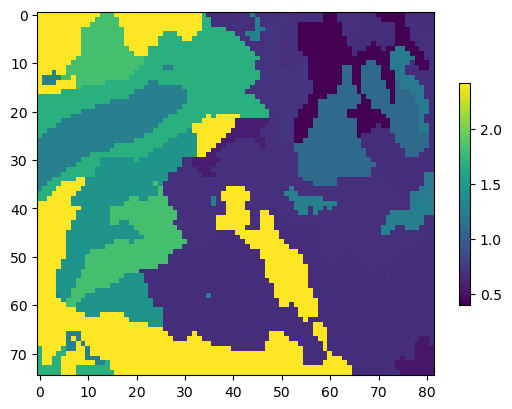

In [45]:
ksat_raster = os.path.join(data_path, "ksat.img")
rstr = flopy.utils.Raster.load(ksat_raster)
vks = rstr.resample_to_grid(
    modelgrid,
    rstr.bands[0],
    method="nearest"
)

vks[vks == rstr.nodatavals[0]] = np.nan
vks[np.isnan(vks)] = np.nanmean(vks)
vks *= 0.0864 
ims = plt.imshow(vks)
plt.colorbar(shrink=0.6); # um per sec to m per day

#### Creating a UZF package 

Now that we have some climate and soils data we can create a UZF package from it and add it to the model!

Create the package data and the stress period data info for flopy

In [46]:
modelgrid = gwf.modelgrid
modelgrid.set_coord_info(xoff=xmin, yoff=ymin)
package_data = []
cnt = 0
for i in range(modelgrid.nrow):
    for j in range(modelgrid.ncol):
        if modelgrid.idomain[0, i, j] == 0:
            continue
        
        rec = (cnt, (0, i, j), 1, 0, 1.0, vks[i, j], 0.1, 0.38, 0.1, 3.5)
        package_data.append(rec)
        cnt += 1

period_data = {}
for per in range(gwf.nper):
    spd = []
    cnt = 0
    for i in range(modelgrid.nrow * modelgrid.ncol):
        if modelgrid.idomain.ravel()[i] == 0:
            continue
        rec = (cnt, prcp_monthly[per].ravel()[i], pet_monthly[per].ravel()[i], 0.5, 0.2, -1.1, -75, 1.0)
        spd.append(rec)
        cnt += 1
        
    period_data[per] = spd

In [47]:
uzf = flopy.mf6.ModflowGwfuzf(
    gwf,
    simulate_et=True,
    ntrailwaves=15,
    nwavesets=100,
    packagedata=package_data,
    perioddata=period_data,
    unsat_etwc=True,
    linear_etwc=True,
    simulate_gwseep=True
)

### Now to create a simple river package from NHD flowlines 

We can use the intersection routines that have been presented thus far to create a river package for the sagehen model. 

The first step is to get the NHD flowlines for the basin

<AxesSubplot:>

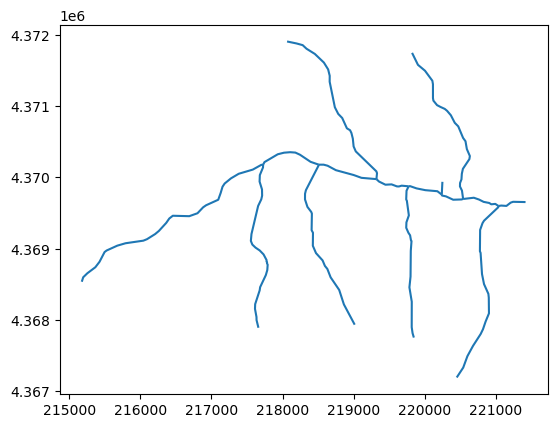

In [48]:
# get the basin boundary
nldi = nhd.NLDI()
basin = nldi.get_basins(station_id)

# get nhd plus medium resolution data
mr = nhd.WaterData("nhdflowline_network")
nhdp_mr = mr.bygeom(basin.geometry[0])
nhdp_mr = nhdp_mr.to_crs(epsg=epsg)
nhdp_mr.plot()

Excellent! Now we have all of the flow lines for the Sagehen watershed. But what if we want to identify the main stem? 

,geometry,nhdplus_comid
0,"LINESTRING (221038.128 4369598.916, 221076.482...",8933522
1,"LINESTRING (220540.741 4369697.577, 220691.351...",8933524
2,"LINESTRING (220240.365 4369758.860, 220244.995...",8933520
3,"LINESTRING (219769.843 4369876.335, 219795.329...",8934344
4,"LINESTRING (219321.052 4369977.090, 219357.890...",8933512
5,"LINESTRING (218509.989 4370180.464, 218578.637...",8933508
6,"LINESTRING (217726.838 4370179.373, 217746.044...",8933496
7,"LINESTRING (215175.791 4368533.473, 215195.962...",8933582


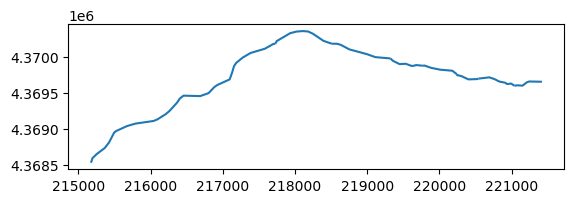

In [49]:
flw_main = nldi.navigate_byid(
    fsource="nwissite",
    fid=f"USGS-{station_id}",
    navigation="upstreamMain",
    source="flowlines",
    distance=1000,
)
flw_main = flw_main.to_crs(epsg=epsg)
flw_main.plot()
flw_main

Great! Now we can start processing data to create a river package. We can first identify our main stem cells.

In [50]:
main_stem = []
gx = GridIntersect(modelgrid)
for iloc, row in flw_main.iterrows():
    results = gx.intersect(row.geometry)
    main_stem += list(results.cellids)
main_stem[0:5]

[(42, 75), (42, 76), (41, 76), (41, 77), (41, 78)]

## Class Exercise:

Use GridIntersect to create a list of tributary cells from the `nhdp_mr` geodataframe. 

**Hint**
Use the `main_stem` list to filter out cells that are associated with the main stem of the river and only store the cells that are associated with tributaries to the main stem.

The cellids for tributaries have been stored previously, so we'll load those up and continue on.


In [51]:
tributaries = []
with open(os.path.join(data_path, "trib_cells.txt")) as foo:
    for line in foo:
        t = line.strip().split(",")
        tributaries.append((int(t[0]), int(t[1])))

#### We can also get daily discharge data to help calculate average monthly stages for the RIV package

We'll use the `hydrofunctions` package to get stage information for our model

Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=10343500&startDT=2021-01-01&endDT=2021-12-31


C:\Users\jlarsen\Documents\anaconda3\envs\pyclass\lib\site-packages\hydrofunctions\hydrofunctions.py:625: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not DF.index.is_monotonic:
C:\Users\jlarsen\AppData\Local\Temp\4\ipykernel_7632\185309193.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gage.rename(columns={i: "stage" for i in list(gage)}, inplace=True)
C:\Users\jlarsen\AppData\Local\Temp\4\ipykernel_7632\185309193.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gage.stage *

<AxesSubplot:xlabel='datetimeUTC'>

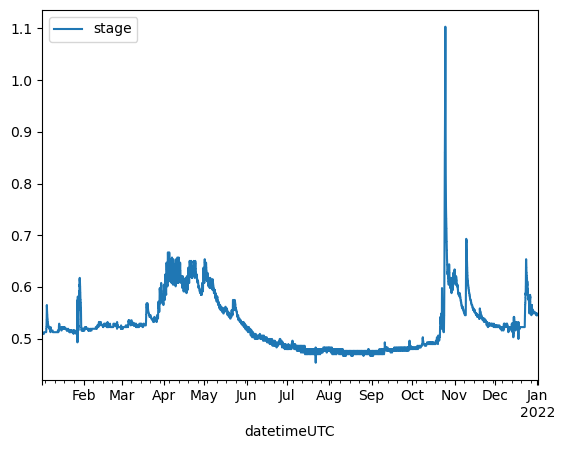

In [52]:
import hydrofunctions as hf
matplotlib.use('module://matplotlib_inline.backend_inline')

query = hf.NWIS(station_id, 'iv', "2021-01-01", "2021-12-31")
gage = query.df()
gage = query.df("stage")
gage.rename(columns={i: "stage" for i in list(gage)}, inplace=True)
# gage.stage *= 0.3284
# gage.plot();
gage.stage *= 0.3284
gage.plot()

Now we can aggregate to a mean monthly state from daily information

C:\Users\jlarsen\AppData\Local\Temp\4\ipykernel_7632\295422761.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gage["month"] = gage.index.month


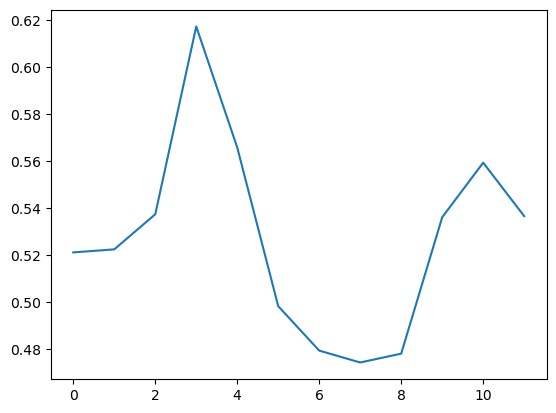

In [53]:
gage["month"] = gage.index.month
gage_mmo = gage.groupby(by=["month"], as_index=False)["stage"].mean()
gage_mmo.stage.plot();

### Now to create the RIV package


In [54]:
cond = 10
rbadj = 1
stage_adj = 0.33

perioddata = {}
for kper, row in gage_mmo.iterrows():
    spd = []
    for (i, j) in main_stem:
        ctop = modelgrid.top[i, j]
        rbed = ctop - rbadj
        rec = ((0, i, j), row.stage + rbed, cond, rbed)
        spd.append(rec)
        
    for (i, j) in tributaries:
        ctop = modelgrid.top[i, j]
        rbed = ctop - (rbadj / 2)
        rec = ((0, i, j), row.stage + rbed, cond, rbed)
    
    perioddata[kper] = spd

perioddata[0][0:5]

[((0, 42, 75), 1936.755825717658, 10, 1936.2347412109375),
 ((0, 42, 76), 1935.5904204442204, 10, 1935.0693359375),
 ((0, 41, 76), 1932.3348052098454, 10, 1931.813720703125),
 ((0, 41, 77), 1930.759243686408, 10, 1930.2381591796875),
 ((0, 41, 78), 1928.2823149754704, 10, 1927.76123046875)]

In [55]:
riv = flopy.mf6.ModflowGwfriv(
    gwf,
    save_flows=True,
    maxbound=len(perioddata[0]),
    stress_period_data=perioddata
)


# Testing the model

In [56]:
sim.write_simulation()
sim.run_simulation();

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model sagehen...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package oc...
    writing package uzf_0...
INFORMATION: nuzfcells in ('gwf6', 'uzf', 'dimensions') changed to 3587 based on size of packagedata
    writing package riv_0...
FloPy is using the following executable to run the model: .\mf6.EXE
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.3.0 release candidate 07/30/2021
                               ***DEVELOP MODE***

  MODFLOW 6 compiled Oct 29 2021 13:12:44 with GFORTRAN compiler (ver. 9.2.0)

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has no

    Solving:  Stress period:     5    Time step:     2
    Solving:  Stress period:     5    Time step:     3
    Solving:  Stress period:     5    Time step:     4
    Solving:  Stress period:     5    Time step:     5
    Solving:  Stress period:     5    Time step:     6
    Solving:  Stress period:     5    Time step:     7
    Solving:  Stress period:     5    Time step:     8
    Solving:  Stress period:     5    Time step:     9
    Solving:  Stress period:     5    Time step:    10
    Solving:  Stress period:     5    Time step:    11
    Solving:  Stress period:     5    Time step:    12
    Solving:  Stress period:     5    Time step:    13
    Solving:  Stress period:     5    Time step:    14
    Solving:  Stress period:     5    Time step:    15
    Solving:  Stress period:     5    Time step:    16
    Solving:  Stress period:     5    Time step:    17
    Solving:  Stress period:     5    Time step:    18
    Solving:  Stress period:     5    Time step:    19
    Solvin

    Solving:  Stress period:     9    Time step:    29
    Solving:  Stress period:     9    Time step:    30
    Solving:  Stress period:    10    Time step:     1
    Solving:  Stress period:    10    Time step:     2
    Solving:  Stress period:    10    Time step:     3
    Solving:  Stress period:    10    Time step:     4
    Solving:  Stress period:    10    Time step:     5
    Solving:  Stress period:    10    Time step:     6
    Solving:  Stress period:    10    Time step:     7
    Solving:  Stress period:    10    Time step:     8
    Solving:  Stress period:    10    Time step:     9
    Solving:  Stress period:    10    Time step:    10
    Solving:  Stress period:    10    Time step:    11
    Solving:  Stress period:    10    Time step:    12
    Solving:  Stress period:    10    Time step:    13
    Solving:  Stress period:    10    Time step:    14
    Solving:  Stress period:    10    Time step:    15
    Solving:  Stress period:    10    Time step:    16
    Solvin

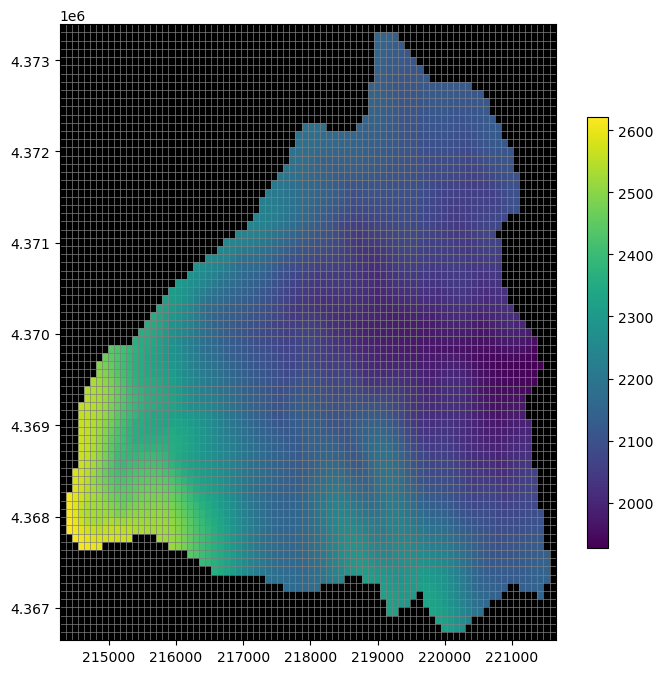

In [57]:
hds = gwf.output.head()
heads = hds.get_alldata()[-1]

fig, ax = plt.subplots(figsize=(8, 8))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
pc = pmv.plot_array(heads, cmap='viridis', masked_values=[1e30, -1e30])
pmv.plot_grid(lw=0.5)
pmv.plot_inactive()
plt.colorbar(pc, shrink=0.7)
plt.show();

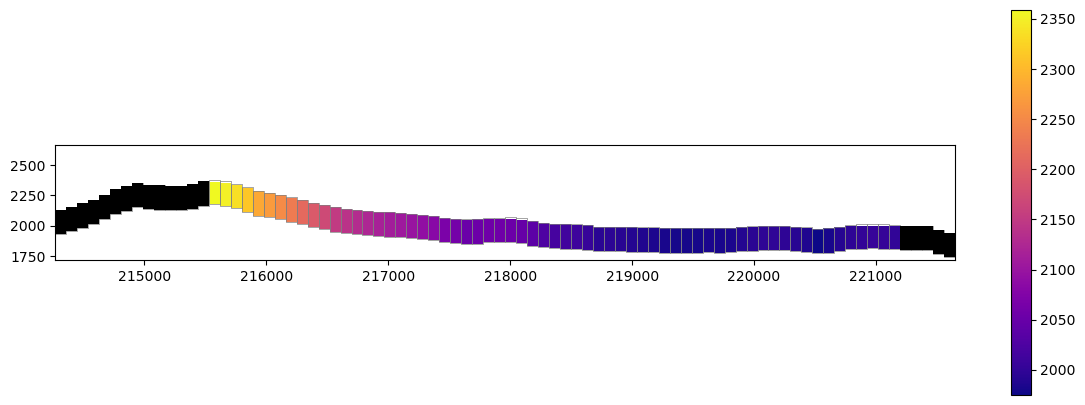

In [58]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_aspect("equal")
xc = flopy.plot.PlotCrossSection(modelgrid=modelgrid, ax=ax, line={"row": 36}, geographic_coords=True)
pc = xc.plot_array(heads, cmap='plasma', head=heads, masked_values=[1e+30])
xc.plot_grid(lw=0.5)
xc.plot_inactive()
plt.colorbar(pc, shrink=0.50)
plt.tight_layout();